In [1]:
import quantileRegression as QReg

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import tables
import pandas as pd
reload(QReg)

Welcome to ROOTaaS 6.06/05


<module 'quantileRegression' from '/mnt/t3nfs01/data01/shome/threiten/QReg/dataMC-1/MTR/quantileRegression.pyc'>

In [14]:
quantiles = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]
workDir = "/mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/camp_3_0_X"
#Y="probeR9"
startEvt=0
stopEvt=-1
#cols=['probePt', 'probePhi', 'probeScEta', 'rho', 'weight', 'run', 'probeR9', 'probeS4', 'probeEtaWidth', 'probePhiWidth', 'probeSigmaIeIe', 'probeCovarianceIetaIphi','probeCovarianceIphiIphi']
qr_data=QReg.quantileRegression('data')
qr_data.loadDFh5(workDir + "/df_data_kinSS_All.h5",startEvt,stopEvt, 12345, False)#, cols)
qr_mc=QReg.quantileRegression('mc')
qr_mc.loadDFh5(workDir + "/df_mc_kinSS_All_clf.h5",startEvt,stopEvt, 12345, False)#, cols)

Loading dataframe from :  /mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/camp_3_0_X/df_data_kinSS_All.h5
Selecting events   [ 0 ,  11699182 ]  out of  11699182
number of events: 11699182
Loading dataframe from :  /mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/camp_3_0_X/df_mc_kinSS_All_clf.h5
Selecting events   [ 0 ,  1378356 ]  out of  1378356
number of events: 1378356


In [15]:
qr_data.df = qr_data.df.query('abs(probeScEta)>1.4442')
qr_mc.df = qr_mc.df.query('abs(probeScEta)>1.4442')

In [19]:
varrs = ['probeR9', 'probeS4', 'probeEtaWidth', 'probePhiWidth', 'probeSigmaIeIe']

for var in varrs:
    
    qr_mc.loadDataWeights(workDir + "/weights/data_weights_EE",var,quantiles)
    qr_mc.loadMcWeights(workDir + "/weights/mc_weights_EE",var,quantiles)
    
    x = ['probePt', 'probeScEta', 'probePhi', 'rho']
    y = var

        #print "Get corrections for ", y, " with quantiles ", quantiles

    y_tmp = []

        # quantile regressions features                                                                    
    X    = qr_mc.df.loc[:,x].values
        # target e.g. y = "R9"                                                                             
    Y    = qr_mc.df[y]
    print "Features: X = ", x, " target y = ", y
        # print X, Y                                                                                       

    if y == 'PhoIso03' or y == 'ChIso03' or y == 'ChIso03worst':
            Y = Y - 0.1*qr_mc.df['rho']

    Y = Y.values.reshape(-1,1)
    Z = np.hstack([X,Y])

    Y_corr = QReg.Corrector(qr_mc.mcclf, qr_mc.dataclf, Z[:,:-1], Z[:,-1])()
    qr_mc.df[y+"_corr"] = Y_corr

Features: X =  ['probePt', 'probeScEta', 'probePhi', 'rho']  target y =  probeR9
Features: X =  ['probePt', 'probeScEta', 'probePhi', 'rho']  target y =  probeS4
Features: X =  ['probePt', 'probeScEta', 'probePhi', 'rho']  target y =  probeEtaWidth
Features: X =  ['probePt', 'probeScEta', 'probePhi', 'rho']  target y =  probePhiWidth
Features: X =  ['probePt', 'probeScEta', 'probePhi', 'rho']  target y =  probeSigmaIeIe


In [4]:
def draw_data_mc(bins,corr,data,uncorr=None,figsize=(8,6),var=None,logy=False,ratio=False, outDir=None, label='All'):
    
    binw=bins[1]-bins[0]
    if ratio:
        fig, axes = plt.subplots(2,figsize=figsize,sharex=True,gridspec_kw = {'height_ratios':[3, 1]})
        top = axes[0]
        bottom = axes[1]
    else:
        fig = plt.figure(figsize=figsize)
        axes = None
        top = plt
    fig.tight_layout()
    
    xc = bins[1:]-binw*0.5
    
    corr_label = 'MC'
    if uncorr != None:
        top.bar(xc,uncorr,width=binw,label='MC uncorr',alpha=0.5,color='red',linewidth=0.)
        corr_label += ' corr'
    top.bar(xc,corr,width=binw,label=corr_label,alpha=0.5,color='blue',linewidth=0.)
    (_, caps, _) = top.errorbar( xc+binw*0.5, data,ls='None', yerr=np.sqrt(data), xerr=np.ones_like(data)*binw*0.5,
                  color='black', label='data', marker='.')
    for cap in caps:
        cap.set_markeredgewidth(0)
    if axes == None: axes = fig.axes
    
    if ratio:
        rdata = data / corr
        rdata_err = np.sqrt(data) / corr
        corr_color = 'black'
        if uncorr != None:
            rdatau = data / uncorr
            rdatau_err = np.sqrt(data) / uncorr
            (_, caps, _) = bottom.errorbar( xc, rdatau,ls='None', yerr=rdatau_err, xerr=np.ones_like(rdata)*binw*0.5,
                            color='red', marker='.')
            for cap in caps:
                cap.set_markeredgewidth(0)
            corr_color = 'blue'
        (_, caps, _) = bottom.errorbar( xc+binw*0.5, rdata,ls='None', xerr=np.ones_like(rdata)*binw*0.5, yerr=rdata_err, 
                        color=corr_color, marker='.')
        for cap in caps:
            cap.set_markeredgewidth(0)
        bottom.plot( (bins[0],bins[-1]), (1,1), 'k--' )
        bottom.set_ylabel('Data / MC')
        bottom.set_ylim(.5,1.5)
    
    if logy:
        axes[0].set_yscale('log')
    axes[0].set_xlim(bins[0],bins[-1])
    
    unit = None    
    if var != None:
        if type(var) != str:
            var, unit = var
        if unit: var += " (%s)" % unit
        axes[-1].set_xlabel(var)
    ylabel = 'Events / %1.3g' % binw
    if unit:
        ylabel += ' %s' % unit
    axes[0].set_ylabel(ylabel)

    top.legend(loc='best')
    
    if outDir != None:
        fig.savefig(outDir + '/' + var + '_' + label + '.png')
        fig.savefig(outDir + '/' + var + '_' + label + '.pdf')

In [5]:
def data_mc(df_mc,df_data,bins,var,corrlabel="_corr",norm=False, weights='weight'):
    
    if not norm:
        hist_mc_uncorr,_ = np.histogram(df_mc[var].values, density=False, weights=df_mc['norm_weight'].values, bins=bins)
        hist_mc_corr,_ = np.histogram(df_mc['%s%s' % (var,corrlabel) ].values, density=False, weights=df_mc['norm_weight'].values, bins=bins)
    elif norm:
        hist_mc_uncorr,_ = np.histogram(df_mc[var].values, density=True, weights=df_mc[weights].values, bins=bins)
        hist_mc_corr,_ = np.histogram(df_mc['%s%s' % (var,corrlabel) ].values, density=True, weights=df_mc[weights].values, bins=bins)
    
    hist_data,_ =  np.histogram(df_data[var].values, density=False, bins=bins)
    
    if norm:
        hist_mc_uncorr *= hist_data.sum()/hist_mc_uncorr.sum()
        hist_mc_corr *= hist_data.sum()/hist_mc_corr.sum()
    
    
    return hist_mc_uncorr,hist_mc_corr,hist_data

In [6]:
def reweight_mc(df_mc, lumiF, miscF=None, cweights='weight'):
    if miscF!=None:
        df_mc['norm_weight']=df_mc[cweights]*lumiF*miscF
    elif miscF==None:
        df_mc['norm_weight']=df_mc[cweights]*lumiF

In [7]:
reweight_mc(qr_mc.df,41.16)#,5765.4/7181)

In [21]:
def binss(var):
    if var in ['probeS4', 'probeR9']: 
        return np.linspace(0,1,101) 
    if var == 'probeEtaWidth': 
        return np.linspace(0,.05,101)
    if var == 'probePhiWidth': 
        return np.linspace(0,.25,101)
    if var == 'probeSigmaIeIe':
        return np.linspace(0,.05,201)
    else:
        print 'Unknown variable'
        return -1

In [1]:
varrs = ['probeR9', 'probeS4', 'probeEtaWidth', 'probePhiWidth', 'probeSigmaIeIe']

for var in varrs:
    bins=binss(var)
    #print qr_mc.df['norm_weight'], qr_mc.df['weight']
    uncorr, corr, data = data_mc(qr_mc.df, qr_data.df, bins, var, corrlabel="_corr", norm=True, weights='weight_class')
    print data.sum(), uncorr.sum(), corr.sum(), data.sum()/uncorr.sum(), data.sum()/corr.sum() #, data.sum()/corr.sum()
    draw_data_mc(bins, corr, data, uncorr, var=(var,''), logy=False, ratio=True, outDir=workDir + '/plots', label='EE_19q_clf')

NameError: name 'binss' is not defined

10230796 10777456.3361 10775139.0161 0.949277425112 0.949481578357


/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


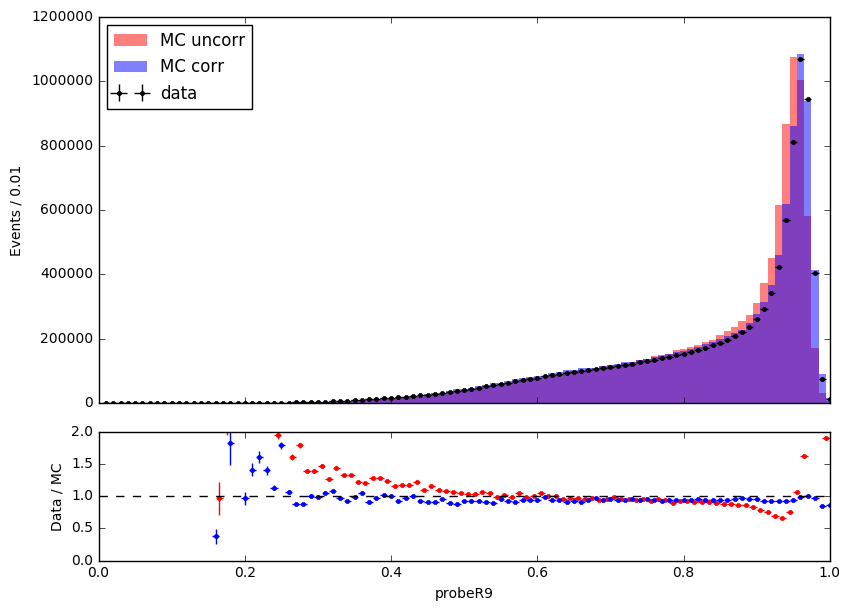

In [64]:
bins=np.linspace(0,1,101)
#print qr_mc.df['norm_weight'], qr_mc.df['weight']
uncorr, corr, data = data_mc(qr_mc.df, qr_data.df, bins, 'probeR9', corrlabel="_corr")#, norm=True)
print data.sum(), uncorr.sum(), corr.sum(), data.sum()/uncorr.sum(), data.sum()/corr.sum() #, data.sum()/corr.sum()
draw_data_mc(bins, corr, data, uncorr, var=('probeR9',''), logy=False, ratio=True, outDir=workDir + '/plots', label='All')

11492792 12009622.2655 12009649.7466 0.9569653188 0.956963129021


/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


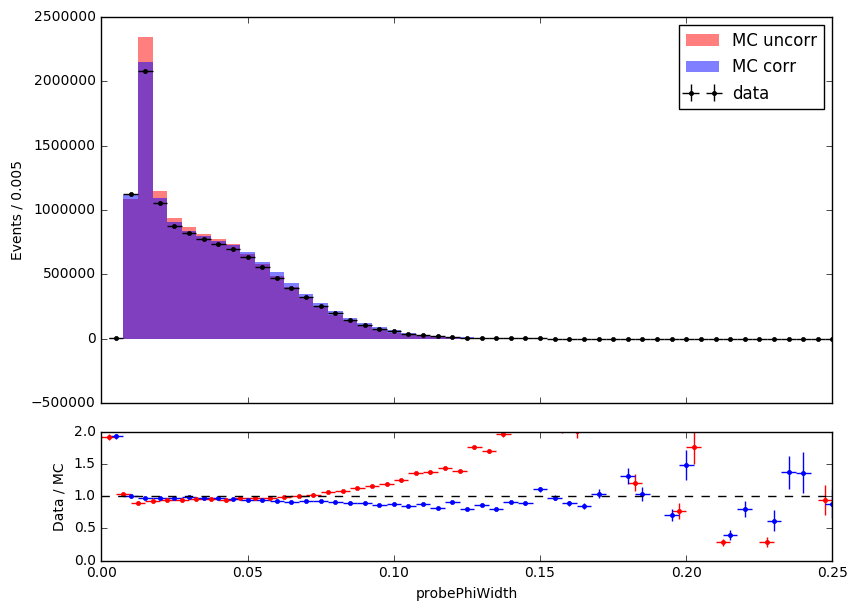

In [50]:
bins=np.linspace(0,.25,51)
#print qr_mc.df['norm_weight'], qr_mc.df['weight']
uncorr, corr, data = data_mc(qr_mc.df, qr_data.df, bins, 'probePhiWidth', corrlabel="_corr")#, norm=True)
print data.sum(), uncorr.sum(), corr.sum(), data.sum()/uncorr.sum(), data.sum()/corr.sum() #, data.sum()/corr.sum()
draw_data_mc(bins, corr, data, uncorr, var=('probePhiWidth',''), logy=False, ratio=True, outDir=workDir + '/plots')

11492296 12009229.8695 12009360.2084 0.956955285636 0.956944899696


/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


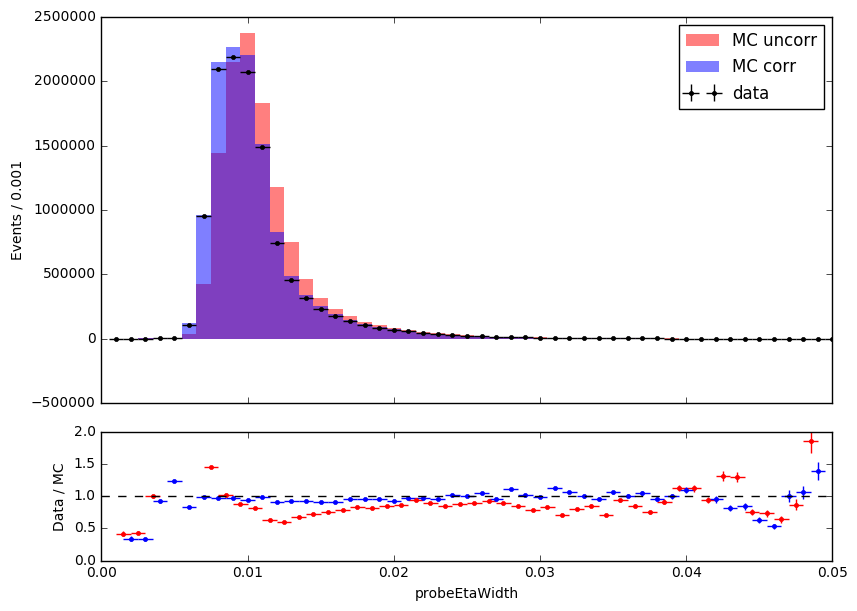

In [51]:
bins=np.linspace(0,.05,51)
#print qr_mc.df['norm_weight'], qr_mc.df['weight']
uncorr, corr, data = data_mc(qr_mc.df, qr_data.df, bins, 'probeEtaWidth', corrlabel="_corr")#, norm=True)
print data.sum(), uncorr.sum(), corr.sum(), data.sum()/uncorr.sum(), data.sum()/corr.sum() #, data.sum()/corr.sum()
draw_data_mc(bins, corr, data, uncorr, var=('probeEtaWidth',''), logy=False, ratio=True, outDir=workDir + '/plots')

/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


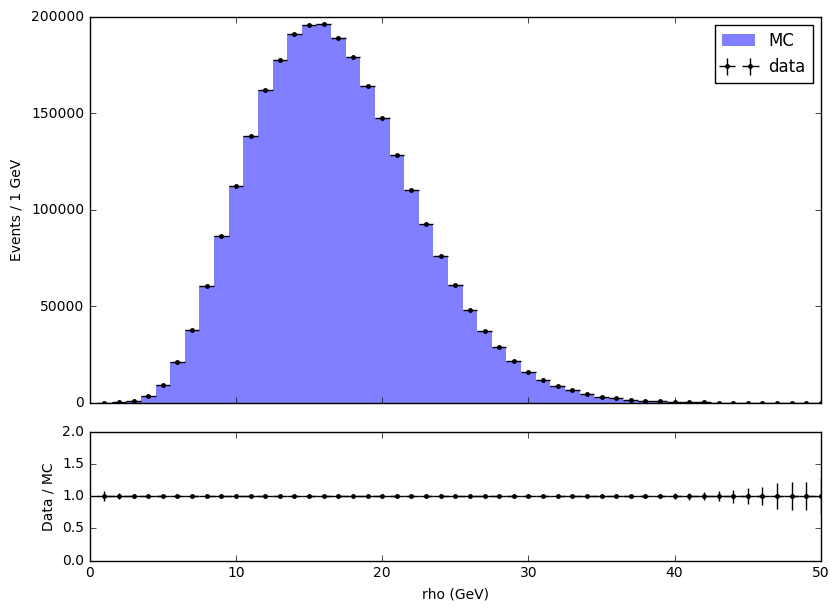

In [20]:
bins=np.linspace(0,50,51)
uncorr, _, data = data_mc(qr_mc.df, qr_data.df, bins, 'rho', corrlabel="", norm=True, weights='weight')
draw_data_mc(bins, uncorr, data, var=('rho', 'GeV'),logy=False, ratio=True, outDir=workDir + '/plots', label='EBEE_RunC_19q')

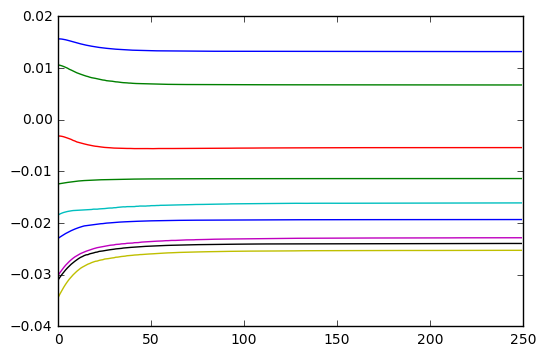

In [27]:
#print qr_mc.dataclf
#for i in range(len(qr_mc.dataclf)):
#    plt.plot(qr_mc.dataclf[i].train_score_)
for i in range(9):
    plt.plot(qr_mc.dataclf[i].train_score_)

In [11]:
print qr_mc.mcclf[0].loss_

In [10]:
quantiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]
var='probeR9'
qr_mc.loadDataWeights(workDir + "/data_weights_EB",var,quantiles)
qr_mc.loadMcWeights(workDir + "/mc_weights_EB",var,quantiles)

X = qr_mc.df.loc[:,['probePt', 'probeEta', 'probePhi', 'rho']]
Y = qr_mc.df['probeR9']
qr_mc.df['qp11']=qr_mc.mcclf[0].predict(X)
qr_mc.df['qp22']=qr_mc.mcclf[1].predict(X)
qr_mc.df['qp33']=qr_mc.mcclf[2].predict(X)
qr_mc.df['qp44']=qr_mc.mcclf[3].predict(X)
qr_mc.df['qp55']=qr_mc.mcclf[4].predict(X)
qr_mc.df['qp66']=qr_mc.mcclf[5].predict(X)
qr_mc.df['qp77']=qr_mc.mcclf[6].predict(X)
qr_mc.df['qp88']=qr_mc.mcclf[7].predict(X)
qr_mc.df['qp99']=qr_mc.mcclf[8].predict(X)

In [11]:
bins = np.linspace(0,1,11)
bbs=[[bins[i],bins[i+1]] for i in range(len(bins)-1)]
qps=['qp11','qp22','qp33','qp44','qp55','qp66','qp77','qp88','qp99']
query_str=map(lambda q: q + ' > @bb[0] and ' + q + ' < @bb[1]',qps)
R9_pred = map(lambda qstr:[qr_mc.df.query(qstr)['probeR9'] for bb in bbs], query_str)

In [12]:
true_quan = [[R9_pred[i][j].quantile(q=quantiles[i]) for j in range(len(R9_pred[i]))] for i in range(len(R9_pred))]
mean_pred_quan = [[qr_mc.df.query(query_str[i])[qps[i]].mean() for bb in bbs] for i in range(len(qps))]
print true_quan
print mean_pred_quan

[[nan, nan, nan, 0.53623806834220888, 0.5817368268966675, 0.63217282295227051, 0.61799736618995671, 0.66845172643661499, 0.78090612888336186, 0.85694653987884517], [nan, nan, nan, 0.63639634847640991, 0.65711220502853385, 0.70652834177017221, 0.72656351327896118, 0.71987435817718504, 0.76008222103118894, 0.85735199451446542], [nan, nan, nan, 0.90633851289749146, 0.71829981207847593, 0.76220703125, 0.7868683934211731, 0.80778301954269416, 0.801768958568573, 0.838406378030777], [nan, nan, nan, nan, 0.6042500972747803, 0.79270071983337398, 0.84066593647003174, 0.84916180372238159, 0.85569796562194833, 0.87181543111801152], [nan, nan, nan, nan, nan, 0.77290382981300354, 0.86571943759918213, 0.89190816879272461, 0.90118557214736938, 0.89965701103210449], [nan, nan, nan, nan, nan, nan, 0.84729516506195068, 0.91182476282119751, 0.92274044752120976, 0.92309273481369025], [nan, nan, nan, nan, nan, nan, nan, 0.91910762190818784, 0.93603351116180411, 0.93723875284194946], [nan, nan, nan, nan, nan

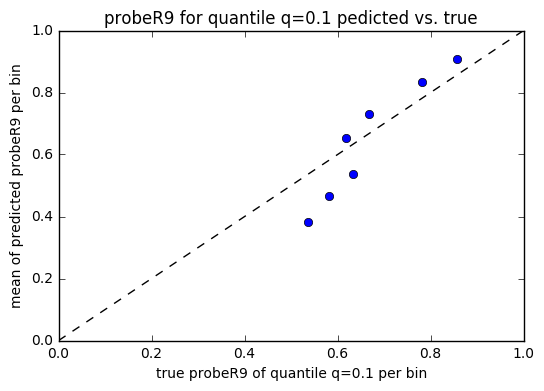

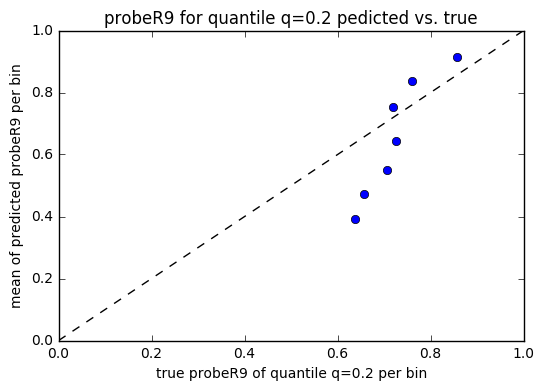

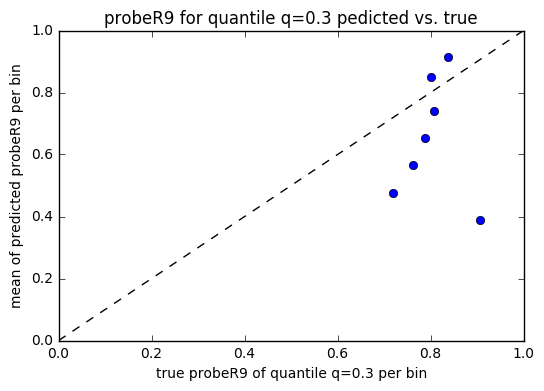

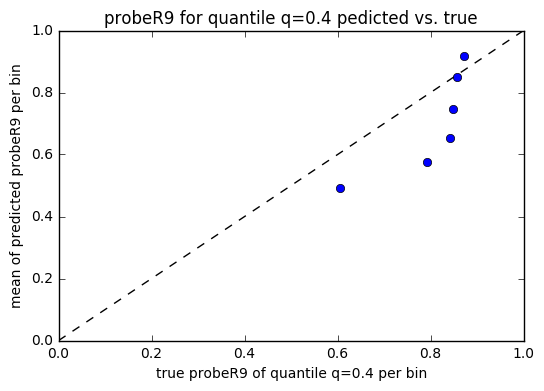

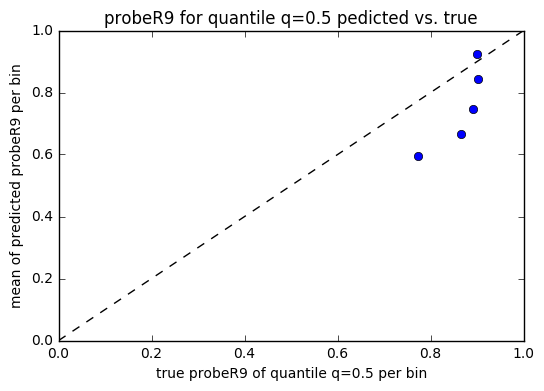

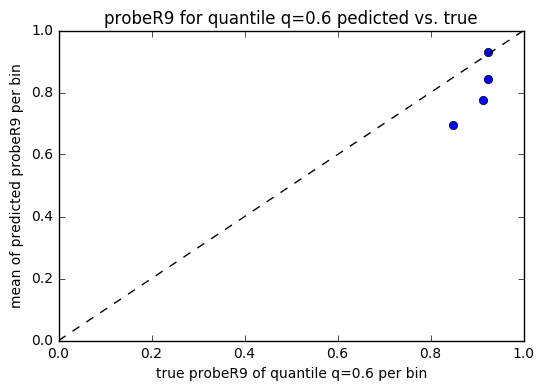

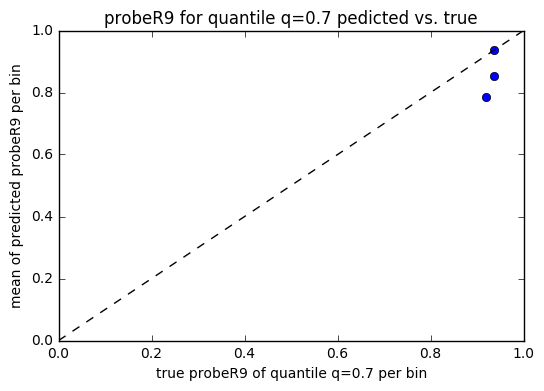

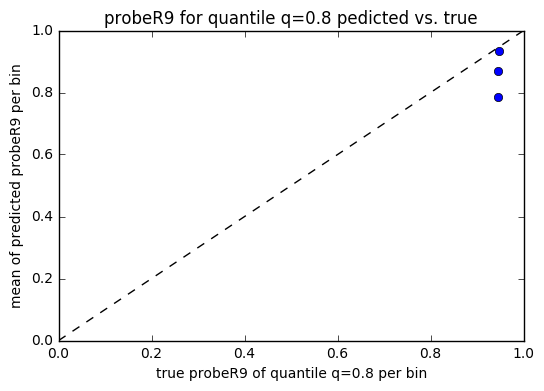

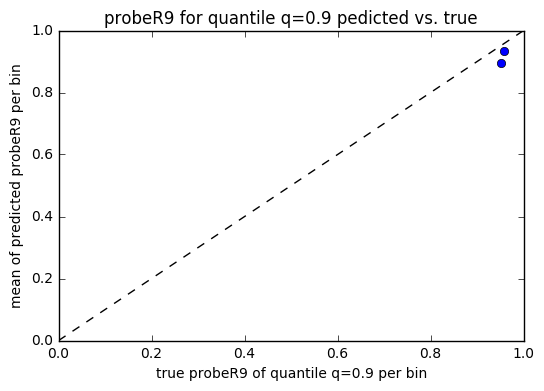

In [13]:
for i in range(len(qps)):
    fig=plt.figure(i)
    plt.plot(true_quan[i],mean_pred_quan[i],'o')
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.ylabel('mean of predicted probeR9 per bin')
    plt.xlabel('true probeR9 of quantile q=' + str(quantiles[i]) + ' per bin')
    plt.title('probeR9 for quantile q=' + str(quantiles[i]) + ' pedicted vs. true')
    plt.savefig('/mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/plots/pred_true_' + str(quantiles[i]) + '.png')
    plt.savefig('/mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/plots/pred_true_' + str(quantiles[i]) + '.pdf')

In [14]:
quantiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]
var='probeR9'
qr_data.loadDataWeights(workDir + "/data_weights_EB",var,quantiles)
qr_data.loadMcWeights(workDir + "/mc_weights_EB",var,quantiles)

X = qr_data.df.loc[:,['probePt', 'probePhi', 'probeEta', 'rho']]
Y = qr_data.df['probeR9']
qr_data.df['qp1']=qr_data.dataclf[0].predict(X)
qr_data.df['qp2']=qr_data.dataclf[1].predict(X)
qr_data.df['qp3']=qr_data.dataclf[2].predict(X)
qr_data.df['qp4']=qr_data.dataclf[3].predict(X)
qr_data.df['qp5']=qr_data.dataclf[4].predict(X)
qr_data.df['qp6']=qr_data.dataclf[5].predict(X)
qr_data.df['qp7']=qr_data.dataclf[6].predict(X)
qr_data.df['qp8']=qr_data.dataclf[7].predict(X)
qr_data.df['qp9']=qr_data.dataclf[8].predict(X)

In [16]:
bins = np.linspace(0,1,11)
bbs=[[bins[i],bins[i+1]] for i in range(len(bins)-1)]
qps=['qp1','qp2','qp3','qp4','qp5','qp6','qp7','qp8','qp9']
query_str=map(lambda q: q + ' > @bb[0] and ' + q + ' < @bb[1]',qps)
R9_pred = map(lambda qstr:[qr_data.df.query(qstr)['probeR9'] for bb in bbs], query_str)

In [17]:
true_quan = [[R9_pred[i][j].quantile(q=quantiles[i]) for j in range(len(R9_pred[i]))] for i in range(len(R9_pred))]
mean_pred_quan = [[qr_data.df.query(query_str[i])[qps[i]].mean() for bb in bbs] for i in range(len(qps))]
print true_quan
print mean_pred_quan

[[nan, nan, 0.49438969492912294, 0.51991840600967409, 0.58523470163345337, 0.63136535882949829, 0.60526885986328127, 0.65519639849662781, 0.77656137943267822, 0.84018040895462032], [nan, nan, nan, 0.61182551383972172, 0.61858052015304565, 0.7010621309280396, 0.73343778848648067, 0.70625284910202024, 0.7509665966033936, 0.85481899976730347], [nan, nan, nan, nan, 0.73749787807464595, 0.71723085045814505, 0.79928635358810418, 0.78260499238967896, 0.79281735420227051, 0.82902033329010005], [nan, nan, nan, nan, nan, 0.75546832084655757, 0.8244158387184144, 0.87499032020568857, 0.83982771635055542, 0.86697489023208618], [nan, nan, nan, nan, nan, 0.80701464414596558, 0.84292590618133545, 0.89936462044715881, 0.89319917559623718, 0.89950117468833923], [nan, nan, nan, nan, nan, nan, 0.87155510187149043, 0.91879171133041382, 0.93609095811843868, 0.92757061719894418], [nan, nan, nan, nan, nan, nan, nan, 0.92541408538818359, 0.94476956129074097, 0.94420782327651975], [nan, nan, nan, nan, nan, nan,

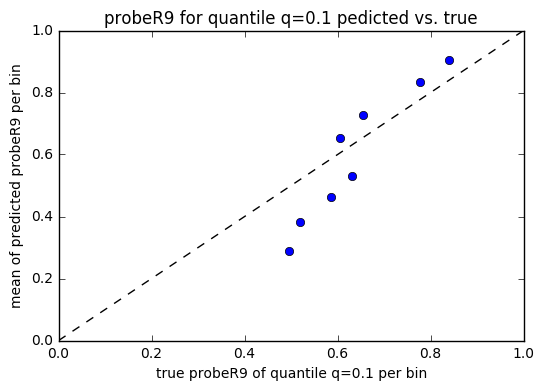

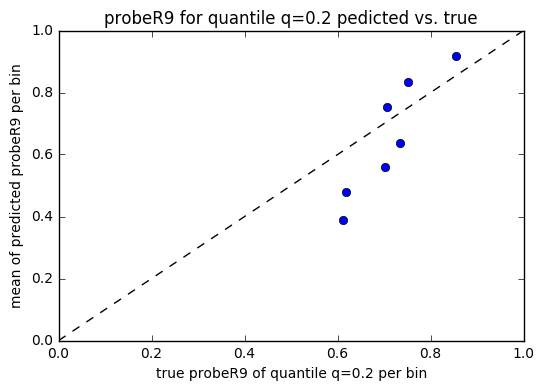

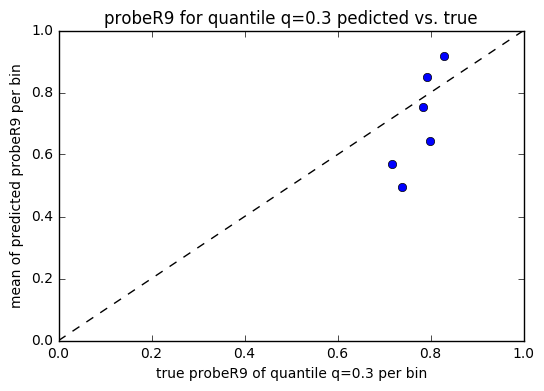

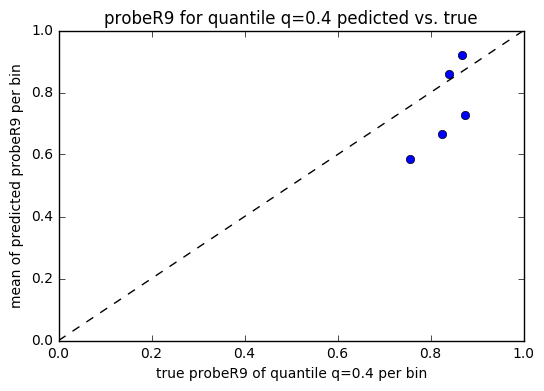

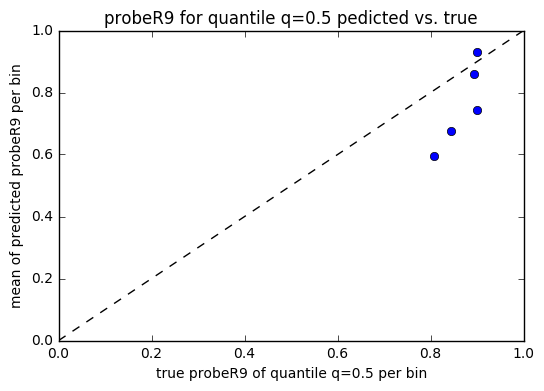

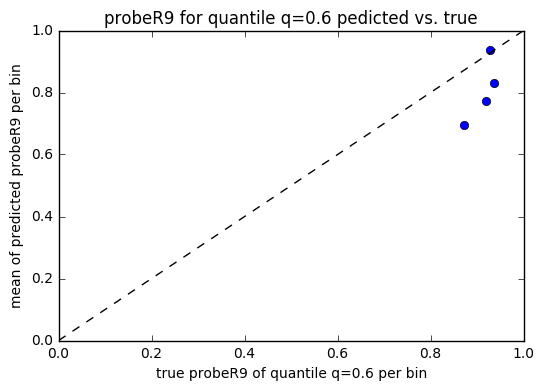

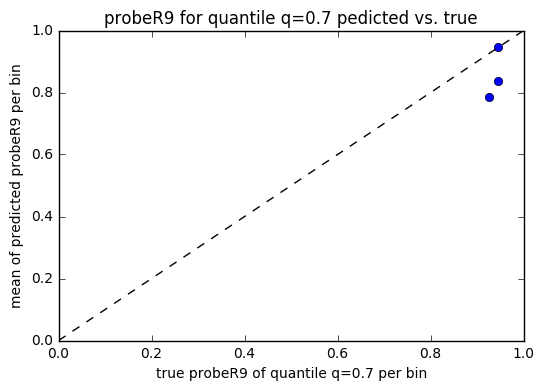

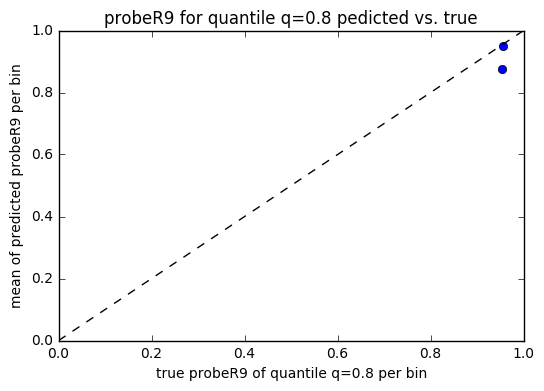

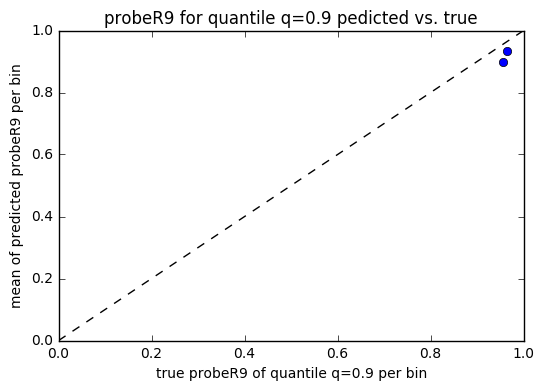

In [18]:
for i in range(len(qps)):
    fig=plt.figure(i)
    plt.plot(true_quan[i],mean_pred_quan[i],'o')
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.ylabel('mean of predicted probeR9 per bin')
    plt.xlabel('true probeR9 of quantile q=' + str(quantiles[i]) + ' per bin')
    plt.title('probeR9 for quantile q=' + str(quantiles[i]) + ' pedicted vs. true')
    plt.savefig('/mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/plots/pred_true_' + str(quantiles[i]) + '_data.png')
    plt.savefig('/mnt/t3nfs01/data01/shome/threiten/QReg/ReReco17_data/plots/pred_true_' + str(quantiles[i]) + '_data.pdf')

In [10]:
qr_mc.df.to_hdf(workDir+'/df_mc_kinSS_All_corr.h5','df',mode='w',format='t')


variable "qr_mc" not defined.

variable "qr_mc.df" not defined.

variable "qr_mc.df.to_h" not defined.
